In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from collections import defaultdict
from sklearn import metrics
from time import time
import numpy as np
import re
from nltk.corpus import stopwords
import unicodedata
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
import threading
import time

In [2]:
# CSV "2022_Urgencia_texto_limpo.csv" with only one column, without header
# read_csv
justificativas_limpo = pd.read_csv("2022_Urgencia_texto_limpo.csv", sep=";", encoding="latin-1")

print(justificativas_limpo.columns)

justificativas_limpo.dropna(inplace=True)

list_justificativa = justificativas_limpo['justificativa_urgencia_viagem'].tolist()

print(len(list_justificativa))

Index(['justificativa_urgencia_viagem'], dtype='object')
384275


In [3]:
random.seed(42)
list_justificativa = random.sample(list_justificativa, 120000)

print(list_justificativa[:10])

['necessario aguardar confirmacao disponibilidade equipe secex participarao obrigatoriamente evento confirmacao ocorreu hoje', 'necessaria correcao pcdps cadastradas anteriormente', 'servidor substituir pro reitora afastada questoes saude', 'familiar constam cronograma departamento', 'periodo data definidos coordenacao juntamente gabinete pessoal pr', 'informo sr documentos referentes necessidade autorizacao despesas encontram anexos', 'necessidade missao', 'necessidade servico', 'acordo aumento volume trabalho deficit acentuado efetivo coordenacao gestao efetivo coge exposto nota tecnica', 'confirmada prazo legal funcao disponibilidade veiculo oficial servidor designado portaria especifica']


In [4]:
n_comp = 50

In [5]:
count_vectorizer = CountVectorizer(max_df=0.9, min_df=0.01)
X_count = count_vectorizer.fit_transform(list_justificativa)


In [6]:
# lsa_count = make_pipeline(TruncatedSVD(n_components=n_comp), Normalizer(copy=False))
# X_count = lsa_count.fit_transform(X_count)
# explained_variance = lsa_count[0].explained_variance_ratio_.sum()

In [7]:
print(X_count.shape)

(120000, 144)


In [8]:
# count the number of entries > 0
count = (X_count[X_count > 0]).shape[1]
min_k = X_count.shape[0] * X_count.shape[1] // count
max_k = min_k * 3
min_k = min_k // 2

# true_k = 300
# cite https://dl.acm.org/doi/pdf/10.1145/99935.99938
print(min_k, max_k)

21 126


In [9]:
sample = list_justificativa
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01)
X = vectorizer.fit_transform(sample)

In [10]:
lsa = make_pipeline(TruncatedSVD(n_components=n_comp, random_state=42), Normalizer(copy=False))
X = lsa.fit_transform(X)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance:.2f} for {n_comp} components")

Explained variance of the SVD step: 0.65 for 50 components


In [18]:
res_df = pd.DataFrame(columns=['k', 'inertia', 'silhouette', 'calinski_harabasz', 'davies_bouldin'], index=range(min_k, max_k + 1))

In [19]:
lock = threading.Lock()

In [20]:
def kmeans(k):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, verbose=False, random_state=42)
    km.fit(X)
    inertia = km.inertia_
    silhouette = metrics.silhouette_score(X, km.labels_, sample_size=40000)
    calinski_harabasz = metrics.calinski_harabasz_score(X, km.labels_)
    davies_bouldin = metrics.davies_bouldin_score(X, km.labels_)
    
    lock.acquire()
    res_df.loc[k] = [k, inertia, silhouette, calinski_harabasz, davies_bouldin]
    lock.release()


In [21]:
with ThreadPoolExecutor(max_workers=4) as exe:
    exe.map(kmeans, range(min_k, max_k + 1))
    
    exe.shutdown(wait=True)

In [32]:
res_df['silhouette'] = res_df['silhouette'].astype(float)
res_df['calinski_harabasz'] = res_df['calinski_harabasz'].astype(float)
res_df['davies_bouldin'] = res_df['davies_bouldin'].astype(float)
res_df['inertia'] = res_df['inertia'].astype(float)

## Elbow Method

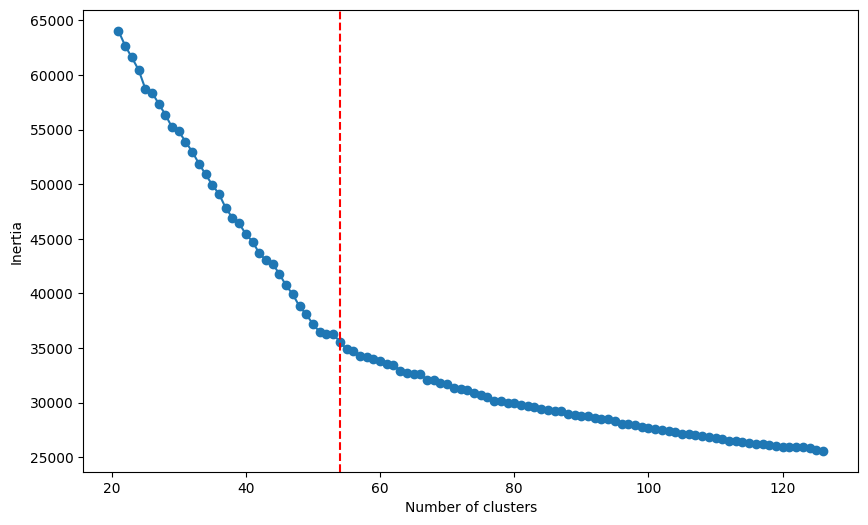

In [42]:
plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['inertia'], marker='o')

plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

plt.axvline(x=54, color='red', linestyle='--')

plt.show()


## Silhouette Coefficient

In [34]:
# max silhouette
print(res_df.loc[res_df['silhouette'].idxmax()])

k                             122
inertia              25913.697321
silhouette               0.418887
calinski_harabasz     3089.385025
davies_bouldin           1.483331
Name: 122, dtype: object


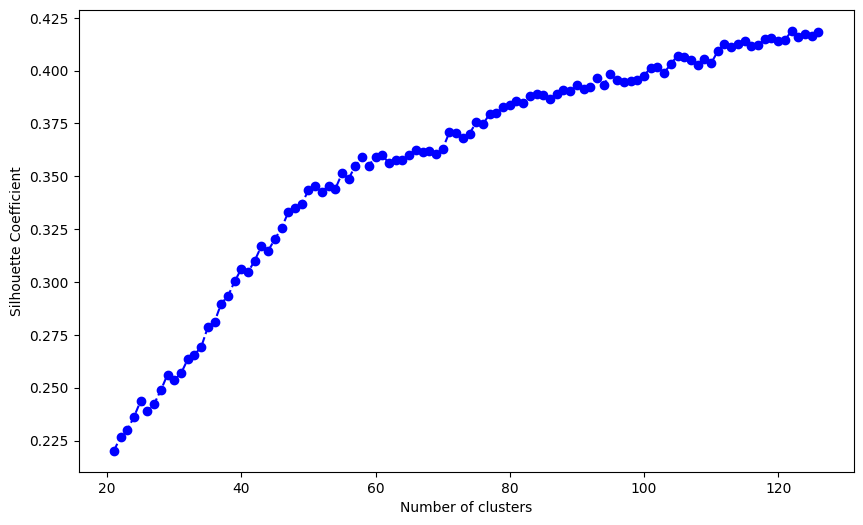

In [35]:
# 2d plot silhouette for each k

plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['silhouette'], marker='o', linestyle='--', color='b')

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

plt.show()



## Calinski-Harabasz Index

In [36]:
# max Calinski-Harabasz
print(res_df.loc[res_df['calinski_harabasz'].idxmax()])

k                             51
inertia              36460.35872
silhouette               0.34538
calinski_harabasz    4622.894726
davies_bouldin          1.241205
Name: 51, dtype: object


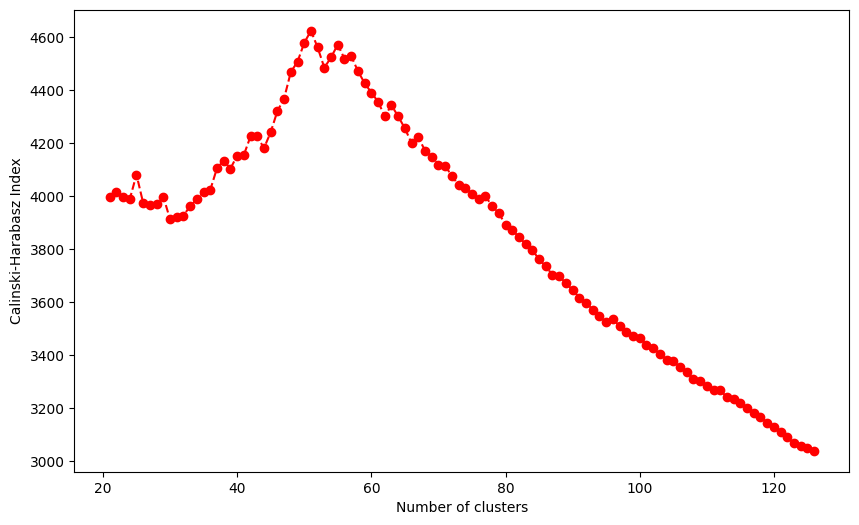

In [37]:
fig = plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['calinski_harabasz'], marker='o', linestyle='--', color='r')

plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')

plt.show()

## Davies-Bouldin Index

In [38]:
# max davies_bouldin
print(res_df.loc[res_df['davies_bouldin'].idxmin()])

k                              52
inertia              36315.537205
silhouette               0.342759
calinski_harabasz     4559.664837
davies_bouldin           1.237218
Name: 52, dtype: object


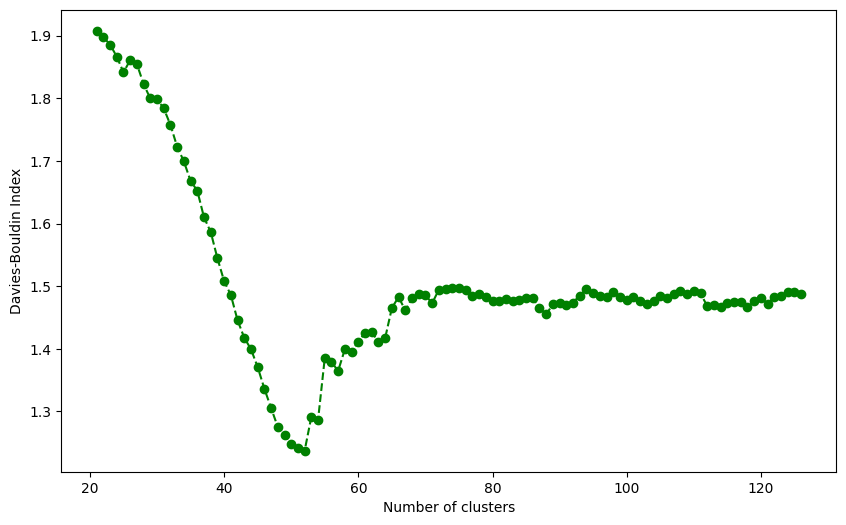

In [39]:
fig = plt.figure(figsize=(10, 6))

plt.plot(res_df['k'], res_df['davies_bouldin'], marker='o', linestyle='--', color='g')

plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')

plt.show()

In [44]:
choosen_k = 52

In [45]:
model = KMeans(n_clusters=choosen_k, init='k-means++', max_iter=200, n_init=1, random_state=42).fit(X)

labels=model.labels_
clusters=pd.DataFrame(list(zip(sample,labels)),columns=['phrase','cluster'])
clusters['cluster'].value_counts()

cluster
2     9395
4     4045
29    3613
32    3342
30    3284
6     3202
8     3048
49    2973
21    2916
33    2629
34    2572
11    2556
25    2533
20    2508
47    2493
10    2466
7     2398
13    2385
19    2375
50    2365
26    2323
41    2284
24    2257
37    2241
22    2235
35    2220
14    2199
0     2156
17    2144
18    2112
38    2088
23    2060
3     2059
48    2025
28    1955
9     1912
39    1851
40    1791
1     1719
44    1663
46    1640
5     1619
43    1588
45    1433
27    1426
36    1380
15    1325
31    1209
51    1187
42     954
16     934
12     913
Name: count, dtype: int64

In [46]:
# quantize the clusters
clusters_count = clusters.groupby('cluster').count()
clusters_count = clusters_count.sort_values(by=['phrase'], ascending=False)

clusters_count.head(10)

,phrase
cluster,
2,9395
4,4045
29,3613
32,3342
30,3284
6,3202
8,3048
49,2973
21,2916


<Axes: xlabel='phrase'>

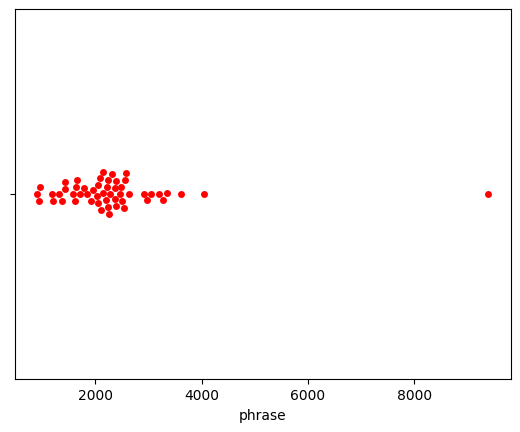

In [47]:
# 1-D swarmplot
sns.swarmplot(x=clusters_count['phrase'], color="red")

In [48]:

#print(clusters.sort_values(by=['cluster']))
# find the centroids
original_space_centroids = lsa[0].inverse_transform(model.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

# for i in range(10):
#     print("#Cluster TOP %d" % (i+1)),
#     print("Cluster %d:" % clusters_count.index[i])

#     for ind in order_centroids[clusters_count.index[i], :10]:
#         print(" %s" % terms[ind])

for i in range(choosen_k):
    print("Cluster %d:" % i),
    print("Cluster size: %d" % clusters_count[clusters_count.index == i].values[0][0])
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind])
    print("------------------------------------------")

    for phr in clusters[clusters['cluster']==i]['phrase'].unique()[:20]:
        print("  %s" % phr)
    print("\n")


Cluster 0:
Cluster size: 2156
 reuniao
 participacao
 participar
 convite
 data
 confirmada
 proposto
 censo
 realizacao
 tecnica
------------------------------------------
  chegou convite participar reuniao
  justifica cumprimento dezessete antecedencia solicitacao diarias passagem aerea servidor francisco jose gomes mesquita disposto instrucao normativa secretaria logistica tecnologia informacao ministerio planejamento orcamento gestao reuniao sr antonio queiroz diretor executivo fapex confirmada email convite anexo
  realizacao reuniao tecnico gerencial censo demografico campina agosto
  realizar reuniao repacs censo demografico
  data reuniao confirmada impossibilitando sems ma programar antecedencia
  acordo cronograma reuniao evento necessidades campus
  reuniao confirmada data inviabilizando agendamento habil deslocamento urgente autorizado chefe gabinete rfb anexo
  realizacao reuniao presencial integracao membros equipe planejamento acoes serem desenvolvidas semestre equipe r

In [49]:
#http://datamining.rutgers.edu/publication/internalmeasures.pdf

## Silhouette Coefficient

In [50]:
metrics.silhouette_score(X, labels, metric='euclidean', sample_size=120000, random_state=42)

0.34362958839272917

## Calinski-Harabasz Index

In [51]:
metrics.calinski_harabasz_score(X, labels)

4559.664836809454

## Davies-Bouldin Index

In [52]:
metrics.davies_bouldin_score(X, labels)

1.237217991659904